# Compute the Frost Days Climate Index

This notebook provides an example of climate data analysis performed in parallel with Dask.

Let TN be the Daily Minimum Near-Surface (usually, 2 meter) Air Temperature. The Frost Days index is the number of days where

\begin{equation*} 
$TN < 0°
\end{equation*}


The notebook will exploit:

  - the **intake** catalog to search and discover the CMIP6 datasets available in the ENES Data Space archive
  - **Dask** and **xarray** to compute the **Frost Days** climate index in parallel
  - **hvPlot**, **Cartopy** and **Matplotlib** to plot the analysis results

Make sure to select the **Python 3 (ipykernel)** Notebook Kernel.

In [94]:
import os
import dask
import intake
import xarray as xr
import numpy as np
import ipywidgets as ipw
import hvplot.xarray
import hvplot.pandas
import panel as pn
import pandas as pd
import panel.widgets as pnw
from os.path import expanduser
home = expanduser("~")
from dask.distributed import Client, LocalCluster
worker_kwargs = {'local_directory': '/home/jovyan'}

### Search & Discover data with **intake-esm**

Open the ESM collection file

In [95]:
esm_file = home+"/data/CMIP6_ESM_colletion_file.json"
col = intake.open_esm_datastore(esm_file)
col.df.head()

,index,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,version,time_range,start_year,end_year,path
0,0,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,day,tas,gn,v20200626,18500101-18591231,1850.0,1859.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...
1,1,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,day,tas,gn,v20200626,18600101-18691231,1860.0,1869.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...
2,2,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,day,tas,gn,v20200626,18700101-18791231,1870.0,1879.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...
3,3,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,day,tas,gn,v20200626,18800101-18891231,1880.0,1889.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...
4,4,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,day,tas,gn,v20200626,18900101-18991231,1890.0,1899.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...


Select the desired *experiment*, *model* and *time resolution*.

For example, we are interested in:
  - `ssp585` experiment from the `CMCC-ESM2` model
  - `tasmin` variable at `daily` frequency
  - `r1i1p1f1` ensemble member

In [96]:
experiments = col.unique().loc[["experiment_id"]][0]

In [97]:
experiment = widgets.Dropdown(
    options=[e for e in experiments],
    value='ssp585',
    description='Experiment:',
)

display(experiment)

Dropdown(description='Experiment:', index=1, options=('historical', 'ssp585', 'ssp245', 'highresSST-present', …

In [98]:
sources = col.df.loc[col.df['experiment_id'] == experiment.value]["source_id"].unique()

In [99]:
source = widgets.Dropdown(
    options=[s for s in sources],
    value='CMCC-ESM2',
    description='Source ID:',
)

display(source)

Dropdown(description='Source ID:', index=8, options=('TaiESM1', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0',…

In [100]:
table_id = widgets.RadioButtons(
    options=['6hrLev','day', 'Amon'],
    value='day',
    description='table ID',
    disabled=False
)
display(table_id)

RadioButtons(description='table ID', index=1, options=('6hrLev', 'day', 'Amon'), value='day')

Perform the query against the data catalogue

In [101]:
import intake
esm_file = home+"/data/CMIP6_ESM_colletion_file.json"
col = intake.open_esm_datastore(esm_file)

query = dict( 
    experiment_id=experiment.value,
    source_id=source.value,
    variable_id="tasmin",
    table_id=table_id.value,
    member_id="r1i1p1f1"
)
cat = col.search(**query)
paths = cat.df['path']#.values
cat.df

,index,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,version,time_range,start_year,end_year,path
0,124347,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,day,tasmin,gn,v20210126,20150101-20391231,2015.0,2039.0,/home/jovyan/data/CMIP6/ScenarioMIP/CMCC/CMCC-...
1,124348,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,day,tasmin,gn,v20210126,20400101-20641231,2040.0,2064.0,/home/jovyan/data/CMIP6/ScenarioMIP/CMCC/CMCC-...
2,124349,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,day,tasmin,gn,v20210126,20650101-20891231,2065.0,2089.0,/home/jovyan/data/CMIP6/ScenarioMIP/CMCC/CMCC-...
3,124350,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,day,tasmin,gn,v20210126,20900101-21001231,2090.0,2100.0,/home/jovyan/data/CMIP6/ScenarioMIP/CMCC/CMCC-...


### Deploy a **Dask** Local cluster

- Create local Scheduler and Workers: this creates a “cluster” of a scheduler and workers running on the local machine
- Connect to and submit computation to the Dask cluster

In [102]:
cluster = LocalCluster(n_workers=2, threads_per_worker=1, **worker_kwargs)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39127,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:37203,Total threads: 1
Dashboard: http://127.0.0.1:39755/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:39951,


### Start the computation

Inspect the data structure

In [103]:
ds = xr.open_mfdataset(paths, combine='nested', concat_dim="time", parallel=True, engine='netcdf4')
ds["tasmin"]

<xarray.DataArray 'tasmin' (time: 31390, lat: 192, lon: 288)>
dask.array<concatenate, shape=(31390, 192, 288), dtype=float32, chunksize=(9125, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height   float64 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TREFHTMN
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2021-01-18T14:12:08Z altered by CMOR: Treated scalar dime...

Plot the Daily Minimum Near-Surface Air Temperature for each timestep in the input datasets


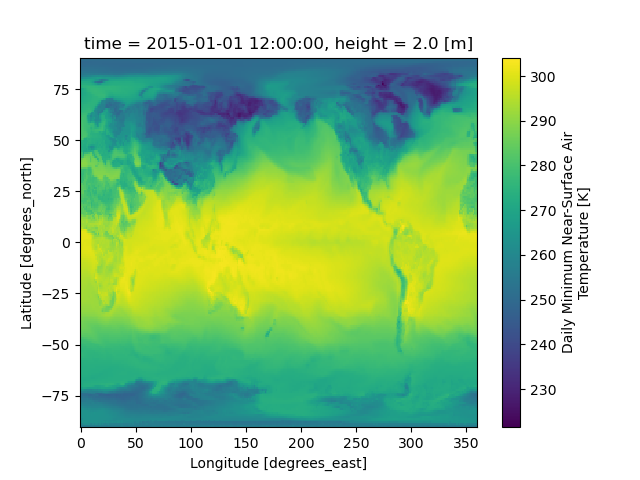

In [104]:
ds["tasmin"].interactive.sel(time=pnw.DiscreteSlider).plot()

Define the EU bounding box

In [105]:
# EUROPE
north= 70.94985882321207
south= 35.049860308608224
east= 40
west= -24.950139509199722

Count the number of frost days on yearly basis over the EU domain:

\begin{equation*} 
    FrostDays = \{day| TN(day) < 273.15 \}
\end{equation*} 

Note that the temperature unit is K.

In [106]:
def calc_frost_days(tasmin_ds, threshold):

    total = (tasmin_ds.sel(lat=slice(south,north), lon=slice(west,east)) < threshold).groupby('time.year').sum()
    return total
 
frost_days = calc_frost_days(ds['tasmin'], 273.15)
result = frost_days.compute()
frost_days

<xarray.DataArray 'tasmin' (year: 86, lat: 38, lon: 33)>
dask.array<stack, shape=(86, 38, 33), dtype=int64, chunksize=(1, 38, 33), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 35.34 36.28 37.23 38.17 ... 67.38 68.32 69.27 70.21
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 35.0 36.25 37.5 38.75 40.0
    height   float64 2.0
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

Use the Player widget from the Panel library to plot the result in an interactive way


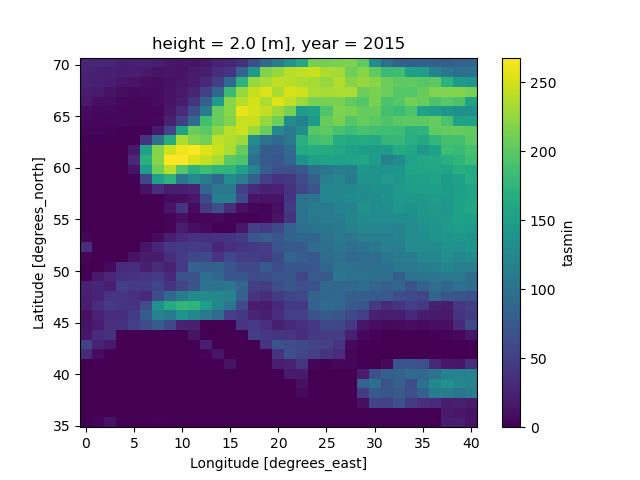

In [107]:
time = pnw.Player(name='year', start=0, end=len(result.year)-1, loop_policy='loop', interval=1000)

result.interactive.isel(year=time).plot()

Export the result to a NetCDF file

In [108]:
result.to_netcdf(path=home+"/work/frost_days.nc", format="NETCDF4",engine="netcdf4")

Check the NetCDF header information through the **ncdump** command-line utility

In [109]:
! ncdump -h '/home/jovyan/work/frost_days.nc'

netcdf frost_days {
dimensions:
	lat = 38 ;
	lon = 33 ;
	year = 86 ;
variables:
	double lat(lat) ;
		lat:_FillValue = NaN ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
	double lon(lon) ;
		lon:_FillValue = NaN ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
	double height ;
		height:_FillValue = NaN ;
		height:units = "m" ;
		height:axis = "Z" ;
		height:positive = "up" ;
		height:long_name = "height" ;
		height:standard_name = "height" ;
	int64 year(year) ;
	int64 tasmin(year, lat, lon) ;
		tasmin:coordinates = "height" ;
}


Create an animated image with **Cartopy** and **Matplotlib** showing the yearly Frost Days in Europe until 2100.

In [67]:
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import imageio
import ipywidgets as widgets

images = []
img=home+'/work/yearly_frost_days_'

start_year=np.min(result.year.values)
end_year=np.max(result.year.values)
#levStep = (np.nanmax(result.values)-np.nanmin(result.values))/20
#clevs = np.arange(np.nanmin(result.values),np.nanmax(result.values)+levStep,levStep)

levStep = (300-0)/20
clevs = np.arange(0,300+levStep,levStep)

for i in result.year.values:
    
    lat = result.sel(year=i).lat.values
    lon = result.sel(year=i).lon.values
    var = result.sel(year=i).values
    var = np.reshape(var, (len(lat), len(lon)))

    fig = plt.figure(figsize=(15, 6), dpi=100)

    #Add Geo axes to the figure with the specified projection (PlateCarree)
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)

    #Draw coastline and gridlines
    ax.coastlines()

    gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    #Wraparound points in longitude
    var_cyclic, lon_cyclic = add_cyclic_point(var, coord=np.asarray(lon))
    x, y = np.meshgrid(lon_cyclic,lat)

    #Set filled contour plot
    cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.Oranges)
    plt.colorbar(cnplot,ax=ax)
    
    plt.title('Frost Days (year ' + str(i)+')')
    plt.savefig(img+str(i)+'.png', dpi=fig.dpi, bbox_inches='tight')
    plt.close()

    images.append(imageio.imread(img+str(i)+'.png')) 
    try:
        os.remove(img+str(i)+'.png')
    except:
        pass
             
args = { 'duration': 0.5 }
imageio.mimsave(home+'/work/Frost Days_{}-{}.gif'.format(start_year,end_year), images, 'gif', **args)

In [110]:
with open(home+'/work/Frost Days_{}-{}.gif'.format(start_year,end_year), "rb") as file:
    image = file.read()

widgets.Image(
    value=image,
    format='gif'
)

Image(value=b'GIF89a\xd6\x02\x0f\x02\x87\x00\x00\xff\xff\xff\xfc\xfc\xfc\xf6\xf6\xf6\xff\xf2\xe6\xf2\xf2\xf2\x…

### Shutdown the **Dask** Local cluster

When you’re done using it, you can shutdown the cluster: this will cleanly close all the connected dask workers, as well as the scheduler. 

In [111]:
client.shutdown()

In [112]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: closed,Using processes: True
Comm: tcp://127.0.0.1:39127,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B
